In [1]:
#Import dependencies into juputer notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error 

import pickle
from flask import Flask, render_template, redirect, jsonify
import pymongo
import json
from bson import json_util


In [2]:
#Import dataset with Gerogia real estate and view table

df = pd.read_csv('RealEstate_Georgia.csv')
df_gdp = pd.read_csv('GAgdpbycounty2020.csv')
df_income = pd.read_csv('ACSST5Y2020.S1901_data_with_overlays_2022-05-17T173521.csv')

In [3]:
df_gdp2 = df_gdp.drop('CAGDP2 Gross domestic product (GDP) by county and metropolitan area 1/', axis=1, inplace=False)
df_gdp2= df_gdp2.rename(columns={'Unnamed: 1': 'county', 'Unnamed: 2': 'GDP (thousands)'}).dropna()
gdp_county_column = df_gdp2["county"].str.split(",", n =1, expand = True) 
df_gdp2["county"]= gdp_county_column[0]
df_gdp_clean = df_gdp2[2:].reset_index(drop=True)

In [4]:
#Census columns = S1901_C03_012E, S1901_C04_001E
cleandata= df_income[['NAME', 'S1901_C03_012E','S1901_C04_012E']]
#Renaming the columns
cleandata_transformed = cleandata.rename(columns={"NAME": "name",
                                                          "S1901_C03_012E": "Married Family Income",
                                                          "S1901_C04_012E": "Nonfamily Income"})
cleandata_transformed["county"] = cleandata_transformed["name"].str.replace(' County, Georgia', '')
census_clean = cleandata_transformed.dropna().reset_index().drop(columns = ['name','index'])
census_clean = census_clean[1:160].reset_index(drop=True)
census_clean["Married Family Income"] = census_clean["Married Family Income"].astype('int')
census_clean["Nonfamily Income"] = census_clean["Nonfamily Income"].astype('int')

In [5]:
df_mergefiles1 = pd.merge(census_clean, df_gdp_clean, on="county", how="outer")
df_mergefiles1.head(5)

,Married Family Income,Nonfamily Income,county,GDP (thousands)
0,51846,19473,Appling,1742236.0
1,50475,23306,Atkinson,253660.0
2,68659,20313,Bacon,395691.0
3,64063,18654,Baker,68982.0
4,80328,26492,Baldwin,1408986.0


In [6]:
#Cleaning Data
df.drop_duplicates()
df_cln = df.loc[(df.is_bankOwned == False) & (df.is_forAuction == False)& (df.homeType != 'LOT')]
df_cln['Month'] = df_cln['datePostedString'].str[0].astype('int')
df_cln = df_cln.loc[(df_cln.yearBuilt < 2022) & (df_cln.yearBuilt > 1800) ]
drop_columns = ['Unnamed: 0', 'id', 'stateId', 'countyId', 'cityId', 'country',
       'is_bankOwned', 'is_forAuction', 'event', 'time','state',
       'streetAddress', 'hasBadGeocode',#'homeType',
       'description', 'currency', 'livingAreaValue',
       'lotAreaUnits', 'buildingArea', 
       'garageSpaces', 'hasPetsAllowed','datePostedString']
df_ready = df_cln.drop(columns=drop_columns).dropna()
df_ready["county"] = df_ready["county"].str.replace(' County', '')
df_ready["county"] = df_ready["county"].str.replace('Dekalb', 'DeKalb')
df_ready

#(df_cln.homeType == 'SINGLE_FAMILY') & 

/Users/ramon/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,price,pricePerSquareFoot,city,yearBuilt,zipcode,longitude,latitude,livingArea,bathrooms,bedrooms,parking,hasGarage,levels,pool,spa,isNewConstruction,homeType,county,Month
0,169900.0,74.0,Waycross,1985.0,31503.0,-82.232475,31.200703,2302.0,3.0,4.0,0.0,0.0,0,0.0,0.0,0.0,SINGLE_FAMILY,Brantley,7
1,159000.0,56.0,Waycross,1910.0,31503.0,-82.365105,31.213835,2864.0,2.0,4.0,0.0,0.0,0,0.0,0.0,0.0,SINGLE_FAMILY,Ware,7
2,45000.0,62.0,Waycross,1945.0,31503.0,-82.327118,31.210838,728.0,1.0,1.0,1.0,0.0,0,0.0,0.0,0.0,SINGLE_FAMILY,Ware,7
3,165000.0,102.0,Waycross,1971.0,31503.0,-82.231300,31.169851,1620.0,2.0,2.0,0.0,0.0,0,0.0,0.0,0.0,SINGLE_FAMILY,Brantley,7
5,173500.0,115.0,Waycross,1980.0,31503.0,-82.300858,31.217014,1512.0,2.0,3.0,0.0,0.0,0,0.0,0.0,0.0,SINGLE_FAMILY,Ware,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13784,100000.0,93.0,Oxford,1986.0,30054.0,-83.855103,33.638157,1081.0,2.0,3.0,1.0,0.0,One,0.0,0.0,0.0,SINGLE_FAMILY,Newton,7
13787,254900.0,156.0,Oxford,1978.0,30054.0,-83.832329,33.698547,1632.0,2.0,3.0,0.0,0.0,One,1.0,0.0,0.0,SINGLE_FAMILY,Walton,7
13801,350000.0,131.0,Oxford,2002.0,30054.0,-83.869751,33.613735,2665.0,4.0,5.0,1.0,1.0,Two,0.0,0.0,0.0,SINGLE_FAMILY,Newton,6
13802,379000.0,193.0,Oxford,2000.0,30054.0,-83.882889,33.669861,1960.0,3.0,3.0,1.0,1.0,One,1.0,1.0,0.0,SINGLE_FAMILY,Newton,6


In [7]:
df_merge = pd.merge(df_ready, df_mergefiles1, on="county", how="left")

df_merge

,price,pricePerSquareFoot,city,yearBuilt,zipcode,longitude,latitude,livingArea,bathrooms,bedrooms,...,levels,pool,spa,isNewConstruction,homeType,county,Month,Married Family Income,Nonfamily Income,GDP (thousands)
0,169900.0,74.0,Waycross,1985.0,31503.0,-82.232475,31.200703,2302.0,3.0,4.0,...,0,0.0,0.0,0.0,SINGLE_FAMILY,Brantley,7,59188,17835,266586.0
1,159000.0,56.0,Waycross,1910.0,31503.0,-82.365105,31.213835,2864.0,2.0,4.0,...,0,0.0,0.0,0.0,SINGLE_FAMILY,Ware,7,61946,22948,1480875.0
2,45000.0,62.0,Waycross,1945.0,31503.0,-82.327118,31.210838,728.0,1.0,1.0,...,0,0.0,0.0,0.0,SINGLE_FAMILY,Ware,7,61946,22948,1480875.0
3,165000.0,102.0,Waycross,1971.0,31503.0,-82.231300,31.169851,1620.0,2.0,2.0,...,0,0.0,0.0,0.0,SINGLE_FAMILY,Brantley,7,59188,17835,266586.0
4,173500.0,115.0,Waycross,1980.0,31503.0,-82.300858,31.217014,1512.0,2.0,3.0,...,0,0.0,0.0,0.0,SINGLE_FAMILY,Ware,7,61946,22948,1480875.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9192,100000.0,93.0,Oxford,1986.0,30054.0,-83.855103,33.638157,1081.0,2.0,3.0,...,One,0.0,0.0,0.0,SINGLE_FAMILY,Newton,7,76637,35625,3210142.0
9193,254900.0,156.0,Oxford,1978.0,30054.0,-83.832329,33.698547,1632.0,2.0,3.0,...,One,1.0,0.0,0.0,SINGLE_FAMILY,Walton,7,89490,34010,2865649.0
9194,350000.0,131.0,Oxford,2002.0,30054.0,-83.869751,33.613735,2665.0,4.0,5.0,...,Two,0.0,0.0,0.0,SINGLE_FAMILY,Newton,6,76637,35625,3210142.0
9195,379000.0,193.0,Oxford,2000.0,30054.0,-83.882889,33.669861,1960.0,3.0,3.0,...,One,1.0,1.0,0.0,SINGLE_FAMILY,Newton,6,76637,35625,3210142.0


In [8]:
#deleting additional columns for clustering analysis
drop_columns2 = ['city','Month','county', 'zipcode', 'levels', 'pricePerSquareFoot', 'parking', 'longitude', 'latitude']
df_cluster = df_merge.drop(columns=drop_columns2)
df_cluster.reset_index(drop=True, inplace=True)
df_cluster

,price,yearBuilt,livingArea,bathrooms,bedrooms,hasGarage,pool,spa,isNewConstruction,homeType,Married Family Income,Nonfamily Income,GDP (thousands)
0,169900.0,1985.0,2302.0,3.0,4.0,0.0,0.0,0.0,0.0,SINGLE_FAMILY,59188,17835,266586.0
1,159000.0,1910.0,2864.0,2.0,4.0,0.0,0.0,0.0,0.0,SINGLE_FAMILY,61946,22948,1480875.0
2,45000.0,1945.0,728.0,1.0,1.0,0.0,0.0,0.0,0.0,SINGLE_FAMILY,61946,22948,1480875.0
3,165000.0,1971.0,1620.0,2.0,2.0,0.0,0.0,0.0,0.0,SINGLE_FAMILY,59188,17835,266586.0
4,173500.0,1980.0,1512.0,2.0,3.0,0.0,0.0,0.0,0.0,SINGLE_FAMILY,61946,22948,1480875.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9192,100000.0,1986.0,1081.0,2.0,3.0,0.0,0.0,0.0,0.0,SINGLE_FAMILY,76637,35625,3210142.0
9193,254900.0,1978.0,1632.0,2.0,3.0,0.0,1.0,0.0,0.0,SINGLE_FAMILY,89490,34010,2865649.0
9194,350000.0,2002.0,2665.0,4.0,5.0,1.0,0.0,0.0,0.0,SINGLE_FAMILY,76637,35625,3210142.0
9195,379000.0,2000.0,1960.0,3.0,3.0,1.0,1.0,1.0,0.0,SINGLE_FAMILY,76637,35625,3210142.0


In [9]:
df_num = pd.get_dummies(df_cluster)

scaler = StandardScaler().fit(df_num)
data_cluster = scaler.transform(df_num)
data_cluster

array([[-0.48820362,  0.08893349,  0.05078359, ..., -0.16404065,
         0.3765306 , -0.23284812],
       [-0.50972298, -2.36709005,  0.35294332, ..., -0.16404065,
         0.3765306 , -0.23284812],
       [-0.73478784, -1.22094573, -0.79547871, ..., -0.16404065,
         0.3765306 , -0.23284812],
       ...,
       [-0.13264063,  0.64563216,  0.24595082, ..., -0.16404065,
         0.3765306 , -0.23284812],
       [-0.07538729,  0.5801382 , -0.13309297, ..., -0.16404065,
         0.3765306 , -0.23284812],
       [-0.15652909,  0.64563216,  0.04702004, ..., -0.16404065,
         0.3765306 , -0.23284812]])

In [10]:
pca = PCA(n_components=0.90)
data_pca = pca.fit_transform(data_cluster)
data_pca.shape

(9197, 10)

In [11]:
pvr = pca.explained_variance_ratio_
print (pvr)

[0.22146113 0.17746652 0.09287421 0.09083373 0.06890054 0.05992409
 0.05864154 0.051721   0.047153   0.03754884]


In [12]:
tsne = TSNE(learning_rate=100)
tsne_data = tsne.fit_transform(data_pca)


/Users/ramon/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


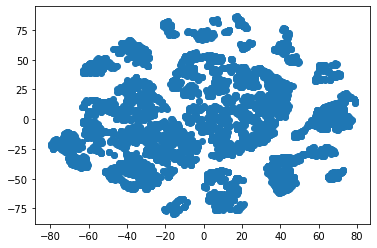

In [13]:
#plotting the results of t-SNE
plt.scatter(tsne_data[:,0], tsne_data[:,1])
plt.show()

In [14]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(data_cluster)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow

,k,inertia
0,1,147152.000000
1,2,126341.636332
2,3,110069.044924
3,4,98757.355463
4,5,88479.834619
5,6,79121.321244
6,7,71114.353635
7,8,65189.932521
8,9,59527.007348
9,10,54743.747732


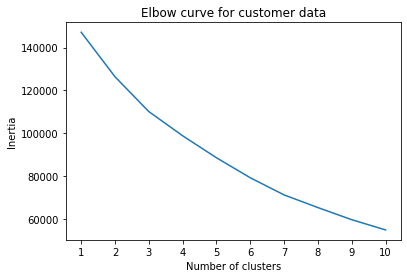

In [15]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

In [16]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=42)
    # Train the model
    model.fit(data)
    # Predict clusters
    predictions = model.predict(data)
    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_
    return data


In [17]:
clusters = get_clusters(4, df_num)
labels = clusters["class"]

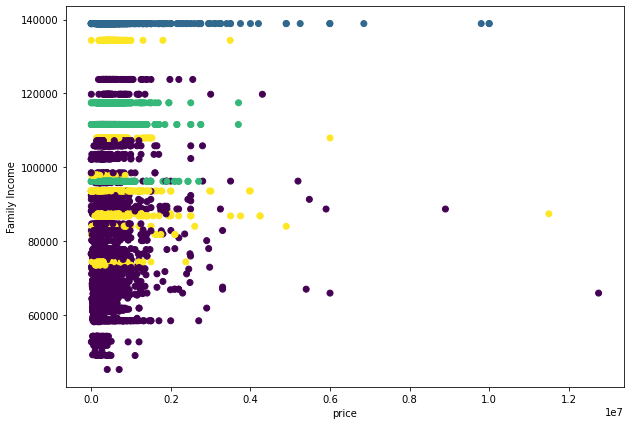

In [18]:
def show_clusters(df):
    plt.figure(figsize=(10,7))
    plt.scatter(df["price"], df["Married Family Income"], c = df["class"])
    plt.xlabel('price')
    plt.ylabel('Family Income')
    plt.show()
    
show_clusters(clusters)

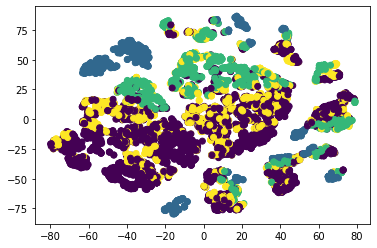

In [19]:
plt.scatter(tsne_data[:,0], tsne_data[:,1], c = df_num["class"])
plt.show()

In [20]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [21]:
def parse_json(data):
    return json.loads(json_util.dumps(data))

In [22]:
# Define database and collection
db = client.project4
collection = db.cluster

#create dictionary
x_l = tsne_data[:,0].tolist()
y_l = tsne_data[:,1].tolist()
c_l = df_num["class"].tolist()

cluster_dict = {
"x": x_l,
"y": y_l,
"c": c_l
}

#Insert dictionary into MongoDB as a Json file
collection.insert_one(cluster_dict)



In [73]:
#data.reset_index(inplace = True)
data_dict = data.to_dict(orient='records')


In [72]:
db = client.project4
collection = db.data
collection.insert_many(data_dict)

In [48]:
#create JSON file
file = open("cluster.json", "w")
json.dump(parse_json(cluster_dict), file)
file.close()



In [ ]:
#df_merge.to_json

In [ ]:
#create dictionary
x_l = tsne_data[:,0].tolist()
y_l = tsne_data[:,1].tolist()
c_l = df_num["class"].tolist()

data_dict = {
"price": df_merge["price"],
"pricePerSquareFoot": y_l,
"c": c_l
}

In [75]:
df_merge.columns

Index(['index', 'price', 'pricePerSquareFoot', 'city', 'yearBuilt', 'zipcode',
       'longitude', 'latitude', 'livingArea', 'bathrooms', 'bedrooms',
       'parking', 'hasGarage', 'levels', 'pool', 'spa', 'isNewConstruction',
       'homeType', 'county', 'Month', 'Married Family Income',
       'Nonfamily Income', 'GDP (thousands)'],
      dtype='object')

In [76]:
drop_columns3 = ['index','city','county', 'levels', 'homeType','longitude', 'latitude']
df_n = df_merge.drop(columns=drop_columns3)

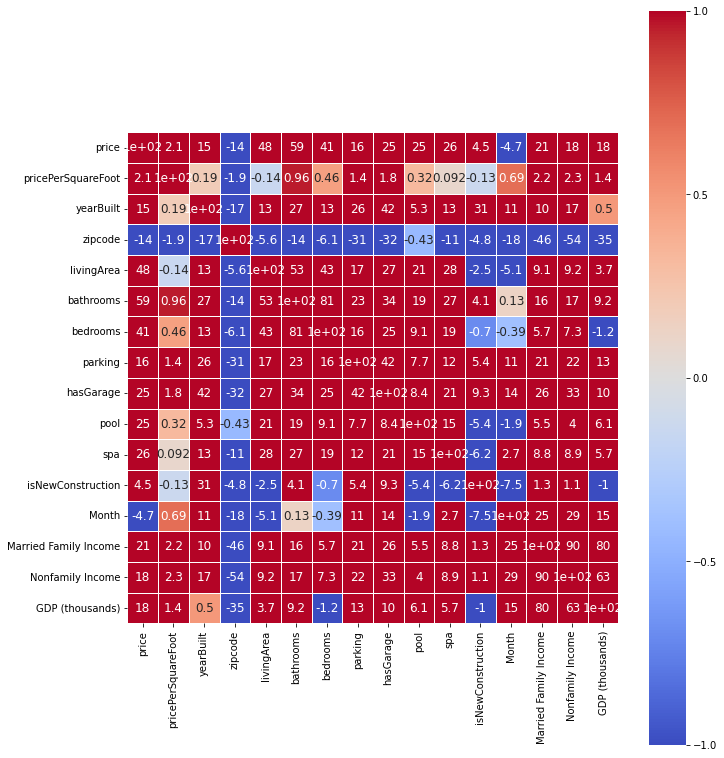

In [77]:

#ANALYSING: Creation of correlation heat map for numerical values.

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sb.heatmap(df_n.corr()*100,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .9,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})


